# Data Analytics



# Ride-Hailing Trip Analysis

This report markdown analyzes the trip assignment method used by an hypothetical ride-hailing app. The app currently assigns new incoming trips to the closest available vehicle using the Haversine distance, referred to as the linear distance. The [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula) calculates the shortest distance over the Earth's surface between two points. However, this method does not accurately reflect actual travel times in urban environments, leading to potential inefficiencies in trip assignments.

## Introduction
In urban settings, the expected travel time from point A to point B is not solely defined by the linear (Haversine) distance. Cities are complex networks with extensive transportation infrastructure, including roads, highways, bridges, and tunnels, designed to increase capacity and reduce travel times. This infrastructure means that the bird distance (linear distance) often fails as a reliable proxy for estimating travel time.

To address this, the concept of road distance is introduced, which calculates the shortest path a vehicle would take using the road network. Road distance accounts for the actual routes vehicles must take, including turns, intersections, and specific road conditions, providing a more realistic estimate of travel time between two points.

This discrepancy between linear and road distances is evident in urban areas like Mexico City (CDMX). In the image below, the blue area indicates regions reachable within a 10-minute drive, demonstrating how actual travel times deviate from the simplistic linear distance model.

<p align="center">
  <img src="![Mexico_DF.png](Mexico_DF.png)"
       alt="CDMX Isochrone Example">
</p>


## Experimental design
The designed expirement is very simple. For a period of 5 days, all trips in 3 cities (Bravos, Pentos and Volantis) have been randomly assigned using linear or road distance:
1. Trips whose trip_id starts with digits 0-8 were assigned using road distance
2. Trips whose trip_id starts with digits 9-f were assigned using linear distance


## Data description
The collected data is available available in the data directory. Each object represent a vehicle_interval that contains the following attributes:<br>
    type: can be going_to_pickup, waiting_for_rider or driving_to_destination
    trip_id: uniquely identifies the trip
    duration: how long the interval last, in seconds
    distance: how far the vehicle moved in this interval, in meters
    city_id: either bravos, pentos and volantis
    started_at: when the interval started, UTC Time
    vehicle_id: uniquely identifies the vehicle
    rider_id: uniquely identifies the rider
    
    
### Example
{<br>
 "duration": 857,<br>
 "distance": 5384,<br>
 "started_at": 1475499600.287,<br>
 "trip_id": "c00cee6963e0dc66e50e271239426914",<br>
 "vehicle_id": "52d38cf1a3240d5cbdcf730f2d9a47d6",<br>
 "city_id": "pentos",<br>
 "type": "driving_to_destination"<br>
 }

## Purpose
The purpose of this analysis is to compare the effectiveness of using linear distance versus road distance for trip assignments. By understanding the differences and their impact on travel times, we can improve the efficiency of the ride-hailing app's trip assignment algorithm.


## Challenge
Try to answer the following questions:
1. Should the company move towards road distance? What's the max price it would make sense to pay per query? (make all the assumptions you need, and make them explicit)
2. How would you improve the experimental design? Would you collect any additional data?





## Loading useful libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import source.config as config
import source.preprocessing_functions as pf
import os

np.random.seed(config.SEED)

## Loading the data

I will load the data from the json file using the corresponding path.

In [2]:
dataframe = pf.load_data(config.PATH_TO_DATA)
dataframe

,duration,distance,started_at,trip_id,vehicle_id,city_id,type
0,857,5384,1.475500e+09,c00cee6963e0dc66e50e271239426914,52d38cf1a3240d5cbdcf730f2d9a47d6,pentos,driving_to_destination
1,245,1248,1.475500e+09,427425e1f4318ca2461168bdd6e4fcbd,8336b28f24c3e7a1e3d582073b164895,volantis,going_to_pickup
2,1249,5847,1.475500e+09,757867f6d7c00ef92a65bfaa3895943f,8885c59374cc539163e83f01ed59fd16,pentos,driving_to_destination
3,471,2585,1.475500e+09,d09d1301d361f7359d0d936557d10f89,81b63920454f70b6755a494e3b28b3a7,bravos,going_to_pickup
4,182,743,1.475500e+09,00f20a701f0ec2519353ef3ffaf75068,b73030977cbad61c9db55418909864fa,pentos,going_to_pickup
...,...,...,...,...,...,...,...
165165,NA,NA,1.475613e+09,d2f81b419daddb90bd701ab9870f47a3,05e4532a59b7bfe65894335d1bc83e4d,volantis,driving_to_destination
165166,NA,NA,1.475613e+09,73a07d4504036997306e0e3330529294,bed6dd187f23b3e8d956bb0d1ab0524a,volantis,waiting_for_rider
165167,NA,NA,1.475613e+09,d98c047d565bd488b17e08594965c479,31cd2f19d27c0c0c0ca386de72866a81,bravos,driving_to_destination
165168,NA,NA,1.475613e+09,ce9a7ae5f76667c9f92b149a1b345a2d,4a555013634506246eed5d801ffbe526,volantis,driving_to_destination


In [3]:
print('The dataset has {} observations and {} columns.'.format(dataframe.shape[0],dataframe.shape[1]))

The dataset has 165170 observations and 7 columns.


## EDA

I will start with some exploratory analysis on this dataset!

### Data Types and Formats

I will check the data types.

In [4]:
dataframe.dtypes

duration       object
distance       object
started_at    float64
trip_id        object
vehicle_id     object
city_id        object
type           object
dtype: object

I see that the variables *duration* and *distance*, which are of numeric types, are actually object types; this is due to the presence of the string 'NA', which I will assume are missing values and treat them ASAP. The rest of the data-types look normal.

### Missing values

Beside the NA strings in *duration* and *distance*, I will check for any other source of missing values within this dataset, and show their percentage.

In [5]:
pf.check_missing_values(dataframe)

,missing_num,missing_percent


There are no other sources of missing values other than NA, presents in the columns: *duration* and *distance*. I will replace this value by NaN and delete them as they won't be useful for any business case.

In [6]:
dataframe = pf.replace_delete_na(dataframe,config.NUM_VARS,'NA')
dataframe

,duration,distance,started_at,trip_id,vehicle_id,city_id,type
0,857.0,5384.0,1.475500e+09,c00cee6963e0dc66e50e271239426914,52d38cf1a3240d5cbdcf730f2d9a47d6,pentos,driving_to_destination
1,245.0,1248.0,1.475500e+09,427425e1f4318ca2461168bdd6e4fcbd,8336b28f24c3e7a1e3d582073b164895,volantis,going_to_pickup
2,1249.0,5847.0,1.475500e+09,757867f6d7c00ef92a65bfaa3895943f,8885c59374cc539163e83f01ed59fd16,pentos,driving_to_destination
3,471.0,2585.0,1.475500e+09,d09d1301d361f7359d0d936557d10f89,81b63920454f70b6755a494e3b28b3a7,bravos,going_to_pickup
4,182.0,743.0,1.475500e+09,00f20a701f0ec2519353ef3ffaf75068,b73030977cbad61c9db55418909864fa,pentos,going_to_pickup
...,...,...,...,...,...,...,...
165131,4.0,0.0,1.475613e+09,0e4ed67de5fc7e16456119bc21143310,3324f1d02d6d82b5403eebfd51dbb3bf,volantis,waiting_for_rider
165139,8.0,3.0,1.475613e+09,99878ca945b1b6d2feef106d0cb9527f,de8dbf79803917d5be58a734b4ae4505,volantis,waiting_for_rider
165148,13.0,26.0,1.475613e+09,5352a94aa14c7e66783dab604aef5313,e4fc541b0dc9afa953b939d4298e574f,volantis,waiting_for_rider
165155,11.0,0.0,1.475613e+09,f6080061c6425a877e34ea92d536017c,68a0408022d899fe4bf64089b27dd199,bravos,waiting_for_rider


### Duplicated data

I will check for duplicated entries within the dataset.

In [7]:
initial_data = dataframe.shape[0]
dataframe = pf.duplicated_data(dataframe)
final_data = dataframe.shape[0]
if initial_data == final_data:
    print("There were no duplicated entries in this dataset.")
else:
    print('There were {} duplicated entries in this dataset'.format(initial_data-final_data))

Removed  0  duplicate rows
There were no duplicated entries in this dataset.


### Creation of the variables `year`, `month`, `day`, `hour`, `minute` and `second`

I will create the variables `year`, `month`, `day`, `hour`, `minute` and `second` from the variable `started_at` to have more indepth information about the time line of the rides. These variables could be useful to later understand outliers.

In [8]:
dataframe = pf.to_datetime(dataframe,'started_at')
dataframe

,duration,distance,started_at,trip_id,vehicle_id,city_id,type,year,month,day,hour,minute,second
0,857.0,5384.0,2016-10-03 13:00:00.286999941,c00cee6963e0dc66e50e271239426914,52d38cf1a3240d5cbdcf730f2d9a47d6,pentos,driving_to_destination,2016,10,3,13,0,0
1,245.0,1248.0,2016-10-03 13:00:00.852999926,427425e1f4318ca2461168bdd6e4fcbd,8336b28f24c3e7a1e3d582073b164895,volantis,going_to_pickup,2016,10,3,13,0,0
2,1249.0,5847.0,2016-10-03 13:00:01.670000076,757867f6d7c00ef92a65bfaa3895943f,8885c59374cc539163e83f01ed59fd16,pentos,driving_to_destination,2016,10,3,13,0,1
3,471.0,2585.0,2016-10-03 13:00:01.841000080,d09d1301d361f7359d0d936557d10f89,81b63920454f70b6755a494e3b28b3a7,bravos,going_to_pickup,2016,10,3,13,0,1
4,182.0,743.0,2016-10-03 13:00:01.970000029,00f20a701f0ec2519353ef3ffaf75068,b73030977cbad61c9db55418909864fa,pentos,going_to_pickup,2016,10,3,13,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
165131,4.0,0.0,2016-10-04 20:35:21.348999977,0e4ed67de5fc7e16456119bc21143310,3324f1d02d6d82b5403eebfd51dbb3bf,volantis,waiting_for_rider,2016,10,4,20,35,21
165139,8.0,3.0,2016-10-04 20:35:33.029000044,99878ca945b1b6d2feef106d0cb9527f,de8dbf79803917d5be58a734b4ae4505,volantis,waiting_for_rider,2016,10,4,20,35,33
165148,13.0,26.0,2016-10-04 20:35:46.073999882,5352a94aa14c7e66783dab604aef5313,e4fc541b0dc9afa953b939d4298e574f,volantis,waiting_for_rider,2016,10,4,20,35,46
165155,11.0,0.0,2016-10-04 20:35:58.878999949,f6080061c6425a877e34ea92d536017c,68a0408022d899fe4bf64089b27dd199,bravos,waiting_for_rider,2016,10,4,20,35,58


In [9]:
dataframe.year.unique()

array([2016])

In [10]:
dataframe.month.unique()

array([10])

I see in the year and month columns unique values are set: 2016 and October. I will delete these two column and keep in mind that the year and month the data was collected, was October 2016.

In [11]:
dataframe.drop(['year','month', 'started_at'],axis=1,inplace=True)

### Creation of the variable distance_type

Recalling the rules:    
    1. Trips whose trip_id starts with digits 0-8 were assigned using road distance
    2. Trips whose trip_id starts with digits 9-f were assigned using linear distance

I will create a new variable with name distance_type to set up the type of distance being measured.

In [12]:
dataframe = pf.id_to_road_lin(dataframe,'trip_id',config.ROAD,'distance_type')
dataframe

,duration,distance,vehicle_id,city_id,type,day,hour,minute,second,distance_type
0,857.0,5384.0,52d38cf1a3240d5cbdcf730f2d9a47d6,pentos,driving_to_destination,3,13,0,0,linear
1,245.0,1248.0,8336b28f24c3e7a1e3d582073b164895,volantis,going_to_pickup,3,13,0,0,road
2,1249.0,5847.0,8885c59374cc539163e83f01ed59fd16,pentos,driving_to_destination,3,13,0,1,road
3,471.0,2585.0,81b63920454f70b6755a494e3b28b3a7,bravos,going_to_pickup,3,13,0,1,linear
4,182.0,743.0,b73030977cbad61c9db55418909864fa,pentos,going_to_pickup,3,13,0,1,road
...,...,...,...,...,...,...,...,...,...,...
165131,4.0,0.0,3324f1d02d6d82b5403eebfd51dbb3bf,volantis,waiting_for_rider,4,20,35,21,road
165139,8.0,3.0,de8dbf79803917d5be58a734b4ae4505,volantis,waiting_for_rider,4,20,35,33,linear
165148,13.0,26.0,e4fc541b0dc9afa953b939d4298e574f,volantis,waiting_for_rider,4,20,35,46,road
165155,11.0,0.0,68a0408022d899fe4bf64089b27dd199,bravos,waiting_for_rider,4,20,35,58,linear


## Outliers analysis

The presence of outliers in both variables *duration* and *distance* may misslead and affect the overall analysis and interpretation of the data. I will plot the distributions of both variables to check whether exist outliers or not?

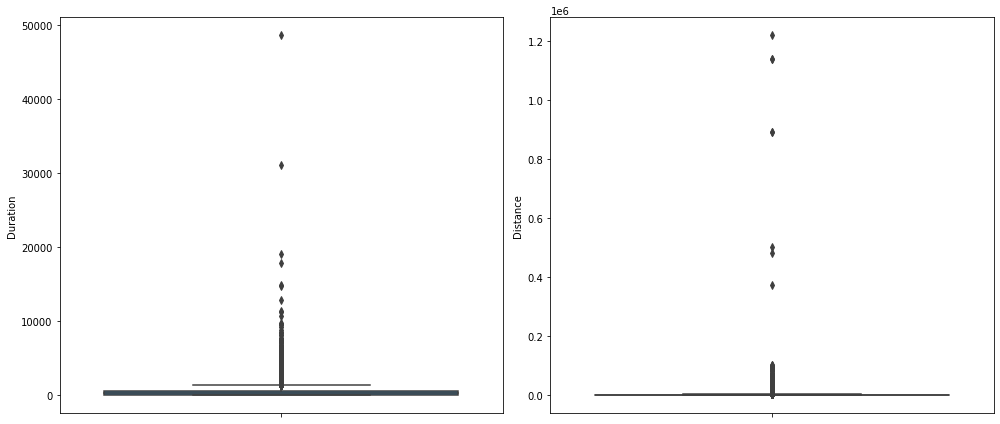

In [13]:
# Creating the boxplots for duration and distance to show the extreme outliers, excluding trip_id
plt.figure(figsize=(14, 6))

# Duration boxplot
plt.subplot(1, 2, 1)
sns.boxplot(y='duration', data=dataframe)
plt.ylabel('Duration')

# Distance boxplot
plt.subplot(1, 2, 2)
sns.boxplot(y='distance', data=dataframe)
plt.ylabel('Distance')

plt.tight_layout()

# Save the figure
plt.savefig('images/outliers.png')

plt.show()

I see some outliers, including extreme ones! They may be due to data quality issues.

### Data Quality issues

The presence of values like `0.0` in the `distance` column while `duration` is greater than `0`, and vice versa, may indicate issues with data quality or inconsistencies in how data was recorded. For example:
1. **Data Entry or Sensor Error**:
   - **Zero Distance with Non-Zero Duration**: This could happen if the GPS or system tracking the distance failed to record the distance properly, but the time was still tracked. It might also occur if the vehicle was moving slowly or was stationary for a long period, resulting in a recorded duration but no significant distance.
   - **Zero Duration with Non-Zero Distance**: This might indicate an issue where the trip duration was not recorded correctly, but the distance was captured. It could also happen if the vehicle covered a distance in a very short time due to a data entry mistake.


2. **Special Cases**:
   - **Zero Distance with Non-Zero Duration**: This might represent trips where the vehicle was stuck in traffic or waiting for a passenger, so no distance was covered but time elapsed.
   - **Zero Duration with Non-Zero Distance**: This could potentially be a case where the system recorded the start and end points but failed to track the actual time.

### Zero distance with non-zero duration

In [14]:
mask = ((dataframe['distance']==0.0) & (dataframe['duration']>0.0))
dataframe[mask]

,duration,distance,vehicle_id,city_id,type,day,hour,minute,second,distance_type
15,5.0,0.0,4479f1258a2a7b3f6cbd51b14072018a,pentos,waiting_for_rider,3,13,0,8,linear
21,5.0,0.0,dbdfbc852599e8209e48e6d6004aa258,pentos,going_to_pickup,3,13,0,12,road
28,246.0,0.0,4e2c5598846f4472f96ab837f7e6613f,volantis,waiting_for_rider,3,13,0,16,road
30,45.0,0.0,dbdfbc852599e8209e48e6d6004aa258,pentos,waiting_for_rider,3,13,0,16,road
51,24.0,0.0,f924ab883e8fd1b2afe628c873f9d5a2,volantis,waiting_for_rider,3,13,0,27,linear
...,...,...,...,...,...,...,...,...,...,...
165098,2.0,0.0,2b40f41fc8f8a815bce1b3bdbd6a4c55,volantis,waiting_for_rider,4,20,34,17,road
165109,17.0,0.0,0092a522e77c7b9db872c07be8e416b2,volantis,waiting_for_rider,4,20,34,33,road
165126,41.0,0.0,63ae0d64e03aee9444ae9e79b53feb5e,bravos,waiting_for_rider,4,20,35,8,road
165131,4.0,0.0,3324f1d02d6d82b5403eebfd51dbb3bf,volantis,waiting_for_rider,4,20,35,21,road


In [15]:
dataframe[mask].day.unique()

array([3, 4])

In [16]:
dataframe[mask].groupby('type')['type'].count()/dataframe[mask].shape[0]*100

type
driving_to_destination     1.859052
going_to_pickup            8.572296
waiting_for_rider         89.568651
Name: type, dtype: float64

In [17]:
dataframe[mask].groupby(['type','city_id'])['type'].count()/dataframe[mask].shape[0]*100

type                    city_id 
driving_to_destination  bravos       0.194411
                        pentos       1.227217
                        volantis     0.437424
going_to_pickup         bravos       2.047388
                        pentos       4.835966
                        volantis     1.688943
waiting_for_rider       bravos      11.956258
                        pentos      54.356015
                        volantis    23.256379
Name: type, dtype: float64

* 16460 rides falling into this category. 
* All of them happened the 3rd and 4th of October 2016, which were Monday and Tuesday.
* Almost 90% of the time was waiting for the rider : 11.96% in Bravos, 54.36% in Pentos and 23.26% in Volantis.
* The case of waiting for the rider, it is expected that no distance was recorder as the vehicle is not moving.

In [18]:
mask = ((dataframe['distance']==0.0) & (dataframe['duration']>0.0) & (dataframe['type']!='waiting_for_rider'))
dataframe[mask]

,duration,distance,vehicle_id,city_id,type,day,hour,minute,second,distance_type
21,5.0,0.0,dbdfbc852599e8209e48e6d6004aa258,pentos,going_to_pickup,3,13,0,12,road
171,14.0,0.0,d691be7f14c78d09d5c0c487c5846bfe,pentos,going_to_pickup,3,13,1,31,road
207,279.0,0.0,071c3a78df37df435f93046e5cb078fb,pentos,going_to_pickup,3,13,1,48,road
223,37.0,0.0,53c625ef89e2b84ff2baba63e06207f2,pentos,going_to_pickup,3,13,1,57,road
272,17.0,0.0,41d8d46d1b755345b2bd065e4e0947ec,volantis,going_to_pickup,3,13,2,21,linear
...,...,...,...,...,...,...,...,...,...,...
164458,7.0,0.0,85079f8c02b9c5994206763328bb3979,pentos,driving_to_destination,4,20,28,45,road
164495,55.0,0.0,85079f8c02b9c5994206763328bb3979,pentos,going_to_pickup,4,20,28,58,linear
164506,156.0,0.0,21303b7b45f1381306fe7600744f44dc,volantis,going_to_pickup,4,20,29,1,linear
165014,9.0,0.0,39e1f021e284a1829857ee111a3cb7a7,volantis,going_to_pickup,4,20,32,43,linear


* 1717 rides that didn't register the distance but they were actually moving and registering time. 
* This is most likely to be an issue of the GPS system that was failing those two days.

In [19]:
mask = ((dataframe['distance']==0.0) & (dataframe['duration']>0.0) & (dataframe['type']=='waiting_for_rider'))
dataframe[mask]

,duration,distance,vehicle_id,city_id,type,day,hour,minute,second,distance_type
15,5.0,0.0,4479f1258a2a7b3f6cbd51b14072018a,pentos,waiting_for_rider,3,13,0,8,linear
28,246.0,0.0,4e2c5598846f4472f96ab837f7e6613f,volantis,waiting_for_rider,3,13,0,16,road
30,45.0,0.0,dbdfbc852599e8209e48e6d6004aa258,pentos,waiting_for_rider,3,13,0,16,road
51,24.0,0.0,f924ab883e8fd1b2afe628c873f9d5a2,volantis,waiting_for_rider,3,13,0,27,linear
56,61.0,0.0,e7ba0bf35b79f4f572b28a1549ad0f0d,bravos,waiting_for_rider,3,13,0,34,linear
...,...,...,...,...,...,...,...,...,...,...
165098,2.0,0.0,2b40f41fc8f8a815bce1b3bdbd6a4c55,volantis,waiting_for_rider,4,20,34,17,road
165109,17.0,0.0,0092a522e77c7b9db872c07be8e416b2,volantis,waiting_for_rider,4,20,34,33,road
165126,41.0,0.0,63ae0d64e03aee9444ae9e79b53feb5e,bravos,waiting_for_rider,4,20,35,8,road
165131,4.0,0.0,3324f1d02d6d82b5403eebfd51dbb3bf,volantis,waiting_for_rider,4,20,35,21,road


In [20]:
dataframe[mask].groupby('distance_type')['duration'].median()

distance_type
linear    9.0
road      9.0
Name: duration, dtype: float64

I see that the waiting times for riders are the same for road and linear distances.

### Zero duration with non-zero distance

In [21]:
mask = ((dataframe['distance']>0.0) & (dataframe['duration']==0.0))
dataframe[mask]

,duration,distance,vehicle_id,city_id,type,day,hour,minute,second,distance_type
2801,0.0,34.0,d77bd910c0ca199e66086fbb5d2a330c,pentos,going_to_pickup,3,13,26,27,road
16378,0.0,543.0,985f05a4c0e147abf311780b03dd3bf3,pentos,going_to_pickup,3,15,42,15,road
24425,0.0,1586.0,0e8cd9e8e1822c615bf4735438541637,pentos,going_to_pickup,3,16,54,45,road
28515,0.0,18.0,95534b76f2c2dd0d38e5056049e5c885,pentos,waiting_for_rider,3,17,33,0,road
45238,0.0,140.0,af849f228883504a1d6b1b289f32fa8c,pentos,going_to_pickup,3,20,3,38,road
49941,0.0,231.0,b90694fe4025a27d6bfab642c1cf50bc,pentos,going_to_pickup,3,20,43,44,linear
67550,0.0,647.0,90c5d3e4ae80434e3d76d5cee1cd0f5f,volantis,going_to_pickup,3,23,5,25,linear
72464,0.0,892.0,01e4305eb8365b0a7d7f6f5f7dc70ab4,pentos,going_to_pickup,3,23,45,29,road
80878,0.0,520.0,4eb2c3815b77e25b294467b73ff8be4d,pentos,going_to_pickup,4,1,23,6,linear
95286,0.0,1453.0,780dc97f3e2909f7111ea1c07c7c23f7,pentos,going_to_pickup,4,10,41,30,linear


In [22]:
dataframe[mask].day.unique()

array([3, 4])

In [23]:
dataframe[mask].groupby('type')['type'].count()/dataframe[mask].shape[0]*100

type
going_to_pickup      92.307692
waiting_for_rider     7.692308
Name: type, dtype: float64

In [24]:
dataframe[mask].groupby(['type','city_id'])['type'].count()/dataframe[mask].shape[0]*100

type               city_id 
going_to_pickup    pentos      76.923077
                   volantis    15.384615
waiting_for_rider  pentos       7.692308
Name: type, dtype: float64

* 13 rides falling into this category. 
* All of them happened the 3rd and 4th of October 2016, which were Monday and Tuesday.
* 92.31% of the time was going to pick up the rider : 76.92% in Pentos and 15.38% in Volantis.
* Potentially, the riding app recorded the start and end points but failed to track the actual time.

I will remove from the dataset all these rides with technical issues, and convert the duration and distance to log scale.

In [25]:
mask = ((dataframe['distance']==0.0) | (dataframe['duration']==0.0))
dataframe = dataframe[~mask]
dataframe.loc[:,'duration'] = np.log(dataframe['duration'])
dataframe.loc[:,'distance'] = np.log(dataframe['distance'])
dataframe

/home/ernesto/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,duration,distance,vehicle_id,city_id,type,day,hour,minute,second,distance_type
0,6.753438,8.591187,52d38cf1a3240d5cbdcf730f2d9a47d6,pentos,driving_to_destination,3,13,0,0,linear
1,5.501258,7.129298,8336b28f24c3e7a1e3d582073b164895,volantis,going_to_pickup,3,13,0,0,road
2,7.130099,8.673684,8885c59374cc539163e83f01ed59fd16,pentos,driving_to_destination,3,13,0,1,road
3,6.154858,7.857481,81b63920454f70b6755a494e3b28b3a7,bravos,going_to_pickup,3,13,0,1,linear
4,5.204007,6.610696,b73030977cbad61c9db55418909864fa,pentos,going_to_pickup,3,13,0,1,road
...,...,...,...,...,...,...,...,...,...,...
165120,3.258097,4.290459,b47fb66e0c2241a4533cbce6785d4126,volantis,waiting_for_rider,4,20,34,57,linear
165125,3.465736,3.891820,55da28d975f8c9509b2ebb9e3fc86934,volantis,waiting_for_rider,4,20,35,3,linear
165139,2.079442,1.098612,de8dbf79803917d5be58a734b4ae4505,volantis,waiting_for_rider,4,20,35,33,linear
165148,2.564949,3.258097,e4fc541b0dc9afa953b939d4298e574f,volantis,waiting_for_rider,4,20,35,46,road


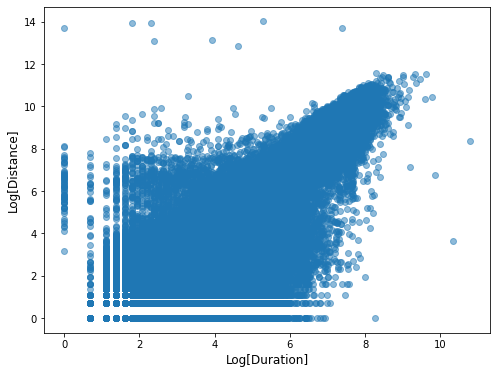

In [26]:
# Create a scatter plot of duration vs distance
plt.figure(figsize=(8, 6))
plt.scatter(dataframe['duration'], dataframe['distance'], alpha=0.5)
plt.xlabel('Log[Duration]', fontsize=12)
plt.ylabel('Log[Distance]', fontsize=12)
plt.xscale('linear')
plt.yscale('linear')
plt.show()

I still see a huge amount of outliers that should be removed before analyzing which type of distance is the best one for the riding app. To do this, I will use the algorithm Isolation Forest, that doesn't depend on a specific distribution of the data. Since the amount of visible outliers is huge, I will set a contamination rate of 20%.

/home/ernesto/anaconda3/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


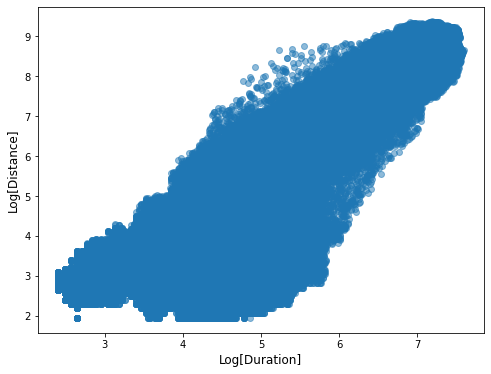

In [27]:
dataframe = pf.remove_outliers(dataframe,['duration','distance'],contamination=0.2)
# Create a scatter plot of duration vs distance
plt.figure(figsize=(8, 6))
plt.scatter(dataframe['duration'], dataframe['distance'], alpha=0.5)
plt.xlabel('Log[Duration]', fontsize=12)
plt.ylabel('Log[Distance]', fontsize=12)
plt.xscale('linear')
plt.yscale('linear')
plt.show()

## Road vs. Linear distances

Once removed the outliers, I can focus on the analysis about the road and linear distances. I will plot the distributions of duration and distance by city and by linear and road distances.

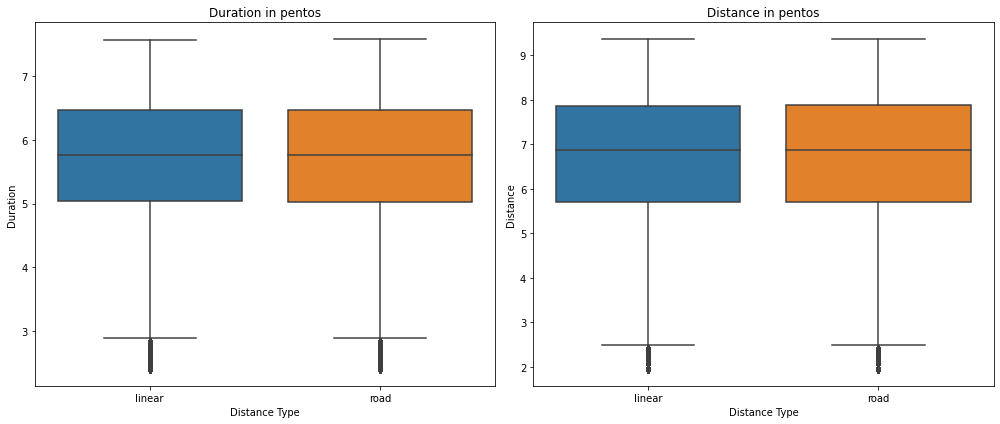

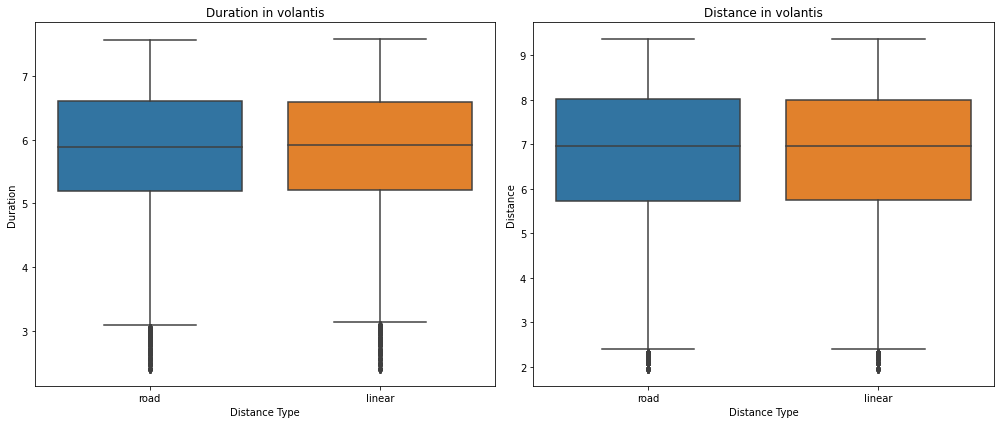

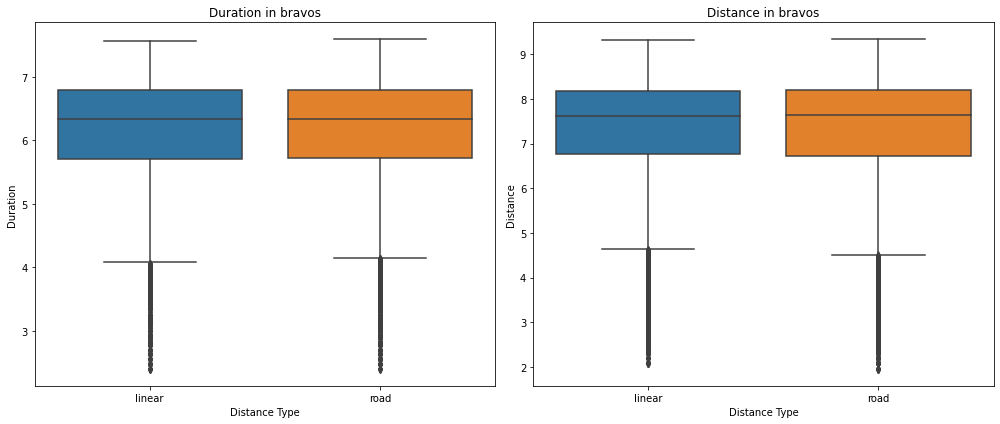

In [28]:
pf.boxplot_distributions(dataframe,'duration','distance','distance_type','city_id')

There are no apparent differences in duration and length of the ride between the distance types, in every city the data was collected. I will run some tests to be sure.

In [29]:
dataframe.groupby(['city_id','distance_type'])['duration','distance'].median()

/home/ernesto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


duration  distance
city_id  distance_type                    
bravos   linear         6.342121  7.625351
         road           6.329721  7.640604
pentos   linear         5.765191  6.874715
         road           5.765191  6.878326
volantis linear         5.916202  6.965080
         road           5.883322  6.951772

The median duration and distance by city and distance type do not differ significantly. I will use the PSI and the Uplift to have an estimate.

In [30]:
result_df = pf.psi_and_uplift_per_city(dataframe, value_column='duration', 
                                    city_column='city_id', type_column='distance_type')
result_df

,city_id,PSI,Uplift
0,pentos,0.000301,0.000000
1,volantis,0.001276,0.005558
2,bravos,0.004129,0.001955


In [31]:
result_df = pf.psi_and_uplift_per_city(dataframe, value_column='distance', 
                                    city_column='city_id', type_column='distance_type')
result_df

,city_id,PSI,Uplift
0,pentos,0.000536,-0.000525
1,volantis,0.001072,0.001911
2,bravos,0.004885,-0.002000


In both cases, duration and distance, and for different cities, there is no significant difference between the road and linear distances, at least for this dataset. I will run t-student test to compare the distributions by city.

### Bravos

In [32]:
mask = ((dataframe.city_id=='bravos')&(dataframe.distance_type=='road'))
braavos_road = dataframe[mask][['duration','distance']]
mask = ((dataframe.city_id=='bravos')&(dataframe.distance_type=='linear'))
braavos_linear = dataframe[mask][['duration','distance']]

In [33]:
pf.t_student_test(braavos_road.distance,braavos_linear.distance)

stat=-0.047, p=0.962
Probably the same distribution.


In [34]:
pf.t_student_test(braavos_road.duration,braavos_linear.duration)

stat=0.366, p=0.714
Probably the same distribution.


### Pentos

In [35]:
mask = ((dataframe.city_id=='pentos')&(dataframe.distance_type=='road'))
pentos_road = dataframe[mask][['duration','distance']]
mask = ((dataframe.city_id=='pentos')&(dataframe.distance_type=='linear'))
pentos_linear = dataframe[mask][['duration','distance']]

In [36]:
pf.t_student_test(pentos_road.distance,pentos_linear.distance)

stat=0.528, p=0.597
Probably the same distribution.


In [37]:
pf.t_student_test(pentos_road.duration,pentos_linear.duration)

stat=-0.376, p=0.707
Probably the same distribution.


### Volantis

In [38]:
mask = ((dataframe.city_id=='volantis')&(dataframe.distance_type=='road'))
volantis_road = dataframe[mask][['duration','distance']]
mask = ((dataframe.city_id=='volantis')&(dataframe.distance_type=='linear'))
volantis_linear = dataframe[mask][['duration','distance']]

In [39]:
pf.t_student_test(volantis_road.distance,volantis_linear.distance)

stat=0.136, p=0.891
Probably the same distribution.


In [40]:
pf.t_student_test(volantis_road.duration,volantis_linear.duration)

stat=-0.726, p=0.468
Probably the same distribution.


T-Student tests showed that the distributions of linear and road distances are probably the same.

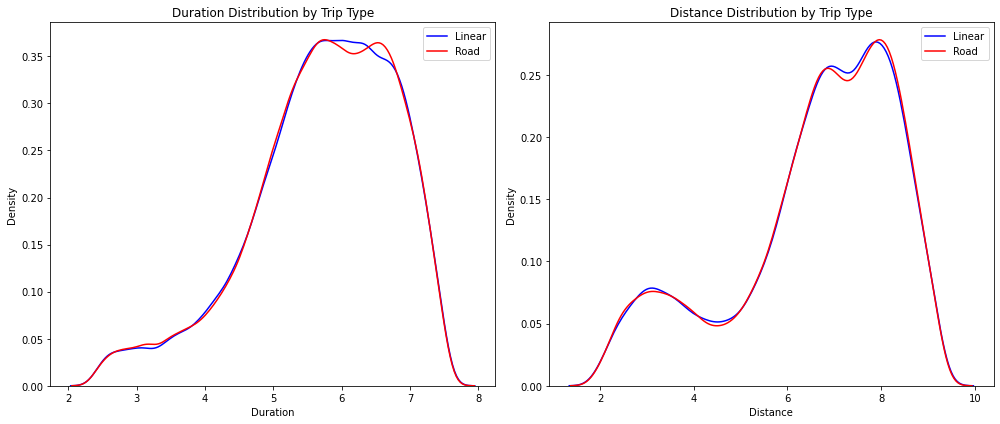

In [41]:
# Plotting the KDE plots for duration and distance
plt.figure(figsize=(14, 6))

# Duration KDE plot
plt.subplot(1, 2, 1)
sns.kdeplot(dataframe[dataframe['distance_type'] == 'linear']['duration'], color='blue', label='Linear')
sns.kdeplot(dataframe[dataframe['distance_type'] == 'road']['duration'], color='red', label='Road')
plt.title('Duration Distribution by Trip Type')
plt.xlabel('Duration')
plt.ylabel('Density')
plt.legend()

# Distance KDE plot
plt.subplot(1, 2, 2)
sns.kdeplot(dataframe[dataframe['distance_type'] == 'linear']['distance'], color='blue', label='Linear')
sns.kdeplot(dataframe[dataframe['distance_type'] == 'road']['distance'], color='red', label='Road')
plt.title('Distance Distribution by Trip Type')
plt.xlabel('Distance')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

### Most and least performant vehicles

In [42]:
result = pf.vehicle_performance(dataframe)
result

{'Most Rides': {'vehicle_id': '3d6cffb28254ad63c58be761ef5b4e7b',
  'total_rides': 109,
  'avg_distance': 6.328046309316471,
  'avg_duration': 5.446278402714446},
 'Least Rides': {'vehicle_id': '000f25e5759a6abb92e0a14d12a15c7e',
  'total_rides': 1,
  'avg_distance': 7.784057002639929,
  'avg_duration': 5.91350300563827},
 'Best Performing Vehicle': {'vehicle_id': '01c8eededd7771ee2b18b5e4a62d7227',
  'total_rides': 13,
  'avg_distance': 6.568662076587387,
  'avg_duration': 5.74644074171717},
 'Worst Performing Vehicle': {'vehicle_id': '3d4cc4db4e9759e78cf79bb07339ecaf',
  'total_rides': 8,
  'avg_distance': 5.9282843568750625,
  'avg_duration': 5.6018716043270995}}

#### **1. Most Rides: Vehicle ID - `3d6cffb28254ad63c58be761ef5b4e7b`**
- **Total Rides**: 109
- **Average Distance**: 6.33 km
- **Average Duration**: 5.45 minutes

**Insight & Recommendations**:
- This vehicle has the highest number of rides, making it a key contributor to the overall business operations. While its average distance and duration are slightly lower than the best-performing vehicle, it is highly utilized, indicating it is efficient at handling high demand.
- Ensure this vehicle is regularly maintained and kept in optimal condition. Given its high usage, preventive maintenance should be prioritized to avoid unexpected breakdowns, which could disrupt operations.
- Consider deploying more vehicles in areas where this vehicle operates, as it likely indicates high demand in those regions.


#### **2. Least Rides: Vehicle ID - `000f25e5759a6abb92e0a14d12a15c7e`**
- **Total Rides**: 1
- **Average Distance**: 7.78 km
- **Average Duration**: 5.91 minutes

**Insight & Recommendations**:
- This vehicle has only completed one ride, indicating underutilization. Despite its low usage, the ride it completed had a relatively long distance and duration, meaning it could be operating in a less-demanding area or on less frequent but longer routes.
- Investigate the reasons for this vehicle’s low activity. Possible causes could include:
  - Operating in low-demand areas.
  - Infrequent deployment or technical issues.
- Reallocate this vehicle to higher-demand areas to improve its utilization. If the vehicle is underperforming due to a mechanical issue or mismanagement, corrective actions should be taken.
  

#### **3. Best Performing Vehicle: Vehicle ID - `01c8eededd7771ee2b18b5e4a62d7227`**
- **Total Rides**: 13
- **Average Distance**: 6.57 km
- **Average Duration**: 5.75 minutes

**Insight & Recommendations**:
- This vehicle consistently delivers high performance, with the highest average distance and duration per ride, suggesting that it is being used on longer routes with greater efficiency. However, the total number of rides (13) indicates it is not as heavily utilized compared to others.
- Consider deploying this vehicle more frequently or in areas with high-demand, long-distance rides, as it excels in covering longer trips efficiently.
- Ensure that this vehicle is reserved for trips where performance matters most, such as long-distance or time-sensitive rides, to maximize its value.

---

#### **4. Worst Performing Vehicle: Vehicle ID - `3d4cc4db4e9759e78cf79bb07339ecaf`**
- **Total Rides**: 8
- **Average Distance**: 5.93 km
- **Average Duration**: 5.60 minutes

**Insight & Recommendations**:
- This vehicle has the lowest average distance and duration, indicating it may be operating inefficiently or in low-demand areas. Its relatively low number of rides also suggests it is underutilized.
- Investigate why this vehicle is performing below average. Possible reasons could include mechanical issues, poor route allocation, or being stationed in areas with low demand.
- Optimize the routes or operational areas for this vehicle, or consider reassignment to a different region where higher demand or longer trips are expected. Alternatively, the vehicle may require maintenance if its low performance is related to technical issues.


### **Overall Strategic Insights**:

1. **Vehicle Utilization Optimization**:
   - The vehicles with the most rides (e.g., vehicle ID `3d6cffb28254ad63c58be761ef5b4e7b`) show where demand is highest. If a few vehicles are handling a disproportionately high number of rides, the business should deploy additional resources in those areas to prevent wear and tear, reduce driver fatigue, and avoid potential service delays.

2. **Improve Utilization of Underperforming Vehicles**:
   - Vehicles like `000f25e5759a6abb92e0a14d12a15c7e` and `3d4cc4db4e9759e78cf79bb07339ecaf` are underutilized. This points to inefficiencies in vehicle allocation or potential mechanical issues. By reallocating these vehicles to higher-demand areas or addressing any technical problems, the business can maximize fleet efficiency.

3. **Long-Distance Efficiency**:
   - Vehicles such as `01c8eededd7771ee2b18b5e4a62d7227` demonstrate higher efficiency on longer trips. These vehicles should be prioritized for longer-distance requests, where their superior performance can have the most impact. The business can leverage this by setting up zones where such vehicles are dispatched for high-demand routes.

4. **Maintenance and Preventive Actions**:
   - High-performing vehicles should be monitored closely for regular maintenance, as they are critical to daily operations. Conversely, underperforming vehicles should undergo diagnostics to identify possible maintenance needs or reallocation to more suitable tasks.

- Understanding the actual travel time for each trip, not just the distance, is critical. Road distance may correlate more strongly with travel time than linear distance, but traffic conditions, congestion, road types (e.g., highways vs. local streets), and traffic lights can all impact travel time. This data should be collected and included for a more precise analysis.

- Travel time can vary significantly based on real-time traffic data, including congestion, accidents, and road closures. Integrating traffic data can improve the accuracy of both linear and road distance estimates.